<a href="https://colab.research.google.com/github/finddrive/-openpose-vs-mediapipe/blob/main/O_vs_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/openpose-counter")
!ls

JR1.mp4  models


In [ ]:
# 判断相对位置
def curr_dy(pre_dy, y_mean1, y_mean2, y_mean3):
    return (pre_dy + np.sign(y_mean2-y_mean1) + np.sign(y_mean3-y_mean2))/3

# 定长数组
def arry_stat(stat,num):
    if len(stat)>=6:
        del stat[0]  
    stat.append(num)
    
# 计数
def if_add(stat,swings):
    if stat[0]==1 and stat[1]==1 and stat[2]==1 and stat[3]==-1 and stat[4]==-1 and stat[5]==-1:
        return swings+1
    else:
        return swings

open_pose

In [ ]:
# Imprt Libraries
from scipy.spatial import distance as dist
import numpy as np
import pandas as pd
import progressbar
import cv2
import time

# Necessary Paths
protoFile = "/content/drive/MyDrive/openpose-counter/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "/content/drive/MyDrive/DriveUploader/pose_iter_160000.caffemodel"

video_path = '/content/drive/MyDrive/openpose-counter/JR4.mp4'
#csv_path = 'out_11.csv'

# Load the model and the weights
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Store the input video specifics
cap = cv2.VideoCapture(video_path)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
ok, frame = cap.read()
(frameHeight, frameWidth) = frame.shape[:2]
h = 500
w = int((h/frameHeight) * frameWidth)

# Dimensions for inputing into the model
inHeight = 368
inWidth = 368

# Set up the progressbar
widgets = ["--[INFO]-- Analyzing Video: ", progressbar.Percentage(), " ",
           progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = n_frames,
                               widgets=widgets).start()
p = 0

data = []
previous_x, previous_y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Define the output
out_path = 'out_11.mp4'
output = cv2.VideoWriter(out_path, 0, fps, (w, h))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
writer = None
(f_h, f_w) = (h, w)
zeros = None

# There are 15 points in the skeleton
pairs = [[0,1], # head 0-1
         [1,2],[1,5], # sholders 1-2,1-5
         [2,3],[3,4],[5,6],[6,7], # arms
         [1,14],[14,11],[14,8], # hips
         [8,9],[9,10],[11,12],[12,13]] # legs
# 头：1，肩膀2,5，中间：14，hip：11，8
dyB_previous_round = 0
posymean = []
frame_count = 0
jump_count = 0
stat_B =[]  #连续6帧的状态



#记录帧
start_time = time.time()
counter = 0
store_F_fps = []
tmp = []

# probability threshold fro prediction of the coordinates
thresh = 0.1 

circle_color, line_color = (0,255,255), (0,255,0)

# Start the iteration
while True:
    ok, frame = cap.read()

    if ok != True:
        break
    
    frame = cv2.resize(frame, (w, h), cv2.INTER_AREA)    
    frame_copy = np.copy(frame)
    
    # Input the frame into the model
    inpBlob = cv2.dnn.blobFromImage(frame_copy, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    
    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    x_data, y_data = [], []
    
    # Iterate through the returned output and store the data
    for i in range(15):
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)  #矩阵中的最小值，最大值，并得到位置
        x = (w * point[0]) / W
        y = (h * point[1]) / H
        
        if prob > thresh:
            points.append((int(x), int(y)))
            x_data.append(x)
            y_data.append(y)
        else :
            points.append((0, 0))
            x_data.append(previous_x[i])
            y_data.append(previous_y[i])
    
    posy = []   #本轮躯干位置 头：1，肩膀：2,5，中间：14，hip：11，8
    for i in range(len(points)):
        cv2.circle(frame_copy, (points[i][0], points[i][1]), 2, circle_color, -1)
        if i==2 or i==5 or i==14 or i==11 or i==8:
          posy.append(points[i][1])
    posymean.append(np.mean(posy))
    if frame_count>1:
        #当前轮的相对位置
        dyB_current_round = curr_dy(dyB_previous_round,posymean[-1],posymean[-2],posymean[-3])
        
        #相较于上一轮是up or down
        arry_stat(stat_B, np.sign(dyB_current_round-dyB_previous_round))
        dyB_previous_round = dyB_current_round                                                         
        if frame_count>9:   #比较i，i+1,i+2->第一轮从第9帧开始
            jump_count = if_add(stat_B,jump_count)

    for pair in pairs:
        partA = pair[0]
        partB = pair[1]
        cv2.line(frame_copy, points[partA], points[partB], line_color, 1, lineType=cv2.LINE_AA)

    cv2.putText(frame_copy,"jumps: {}".format(jump_count),(5,40),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
    
    if writer is None:
        writer = cv2.VideoWriter(out_path, fourcc, fps, (f_w, f_h), True)
        zeros = np.zeros((f_h, f_w), dtype="uint8")
    
    writer.write(cv2.resize(frame_copy,(f_w, f_h)))
    
    #cv2.imshow('frame' ,frame_copy)
    
    #data.append(x_data + y_data)
    previous_x, previous_y = x_data, y_data
    
    p += 1
    frame_count += 1
    pbar.update(p)
    counter += 1

    if (time.time() - start_time) != 0:  # 实时显示帧数
      # cv2.putText(frame_copy, "FPS {0}".format(float('%.1f' % (counter / (time.time() - start_time)))), (30, 430),
      #             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
      tmp.append(round(counter / (time.time() - start_time),4))
      print("tmp",tmp)
      if len(tmp)==10: # 每60帧一个平均值
        store_F_fps.append(round(np.mean(tmp),4))
        print("storage", store_F_fps)
        tmp = []
      counter = 0
      start_time = time.time()
    
    key = cv2.waitKey(1) & 0xFF
 
    if key == ord("q"):
        break

# Save the output data from the video in CSV format
#df = pd.DataFrame(data)
#df.to_csv(csv_path, index = False)
print('save complete')

pbar.finish()
cap.release()
cv2.destroyAllWindows()

--[INFO]-- Analyzing Video:   1% |                             | ETA:   0:09:18

tmp [0.1614]


--[INFO]-- Analyzing Video:   2% |                             | ETA:   0:09:08

tmp [0.1614, 0.1631]


--[INFO]-- Analyzing Video:   3% |                             | ETA:   0:09:04

tmp [0.1614, 0.1631, 0.1606]


--[INFO]-- Analyzing Video:   4% |#                            | ETA:   0:08:59

tmp [0.1614, 0.1631, 0.1606, 0.16]


--[INFO]-- Analyzing Video:   5% |#                            | ETA:   0:08:52

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623]


--[INFO]-- Analyzing Video:   6% |#                            | ETA:   0:08:45

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623, 0.1632]


--[INFO]-- Analyzing Video:   7% |##                           | ETA:   0:08:39

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623, 0.1632, 0.1623]


--[INFO]-- Analyzing Video:   8% |##                           | ETA:   0:08:32

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623, 0.1632, 0.1623, 0.1626]


--[INFO]-- Analyzing Video:   9% |##                           | ETA:   0:08:26

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623, 0.1632, 0.1623, 0.1626, 0.1614]


--[INFO]-- Analyzing Video:  10% |###                          | ETA:   0:08:20

tmp [0.1614, 0.1631, 0.1606, 0.16, 0.1623, 0.1632, 0.1623, 0.1626, 0.1614, 0.1634]
storage [0.162]


--[INFO]-- Analyzing Video:  12% |###                          | ETA:   0:08:14

tmp [0.1603]


--[INFO]-- Analyzing Video:  13% |###                          | ETA:   0:08:08

tmp [0.1603, 0.1613]


--[INFO]-- Analyzing Video:  14% |####                         | ETA:   0:08:01

tmp [0.1603, 0.1613, 0.1628]


--[INFO]-- Analyzing Video:  15% |####                         | ETA:   0:07:55

tmp [0.1603, 0.1613, 0.1628, 0.1615]


--[INFO]-- Analyzing Video:  16% |####                         | ETA:   0:07:49

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618]


--[INFO]-- Analyzing Video:  17% |#####                        | ETA:   0:07:43

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618, 0.1623]


--[INFO]-- Analyzing Video:  18% |#####                        | ETA:   0:07:37

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618, 0.1623, 0.1628]


--[INFO]-- Analyzing Video:  19% |#####                        | ETA:   0:07:30

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618, 0.1623, 0.1628, 0.162]


--[INFO]-- Analyzing Video:  20% |######                       | ETA:   0:07:24

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618, 0.1623, 0.1628, 0.162, 0.1628]


--[INFO]-- Analyzing Video:  21% |######                       | ETA:   0:07:18

tmp [0.1603, 0.1613, 0.1628, 0.1615, 0.1618, 0.1623, 0.1628, 0.162, 0.1628, 0.1624]
storage [0.162, 0.162]


--[INFO]-- Analyzing Video:  23% |######                       | ETA:   0:07:12

tmp [0.1615]


--[INFO]-- Analyzing Video:  24% |#######                      | ETA:   0:07:06

tmp [0.1615, 0.1618]


--[INFO]-- Analyzing Video:  25% |#######                      | ETA:   0:06:59

tmp [0.1615, 0.1618, 0.162]


--[INFO]-- Analyzing Video:  26% |#######                      | ETA:   0:06:53

tmp [0.1615, 0.1618, 0.162, 0.1645]


--[INFO]-- Analyzing Video:  27% |#######                      | ETA:   0:06:47

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623]


--[INFO]-- Analyzing Video:  28% |########                     | ETA:   0:06:40

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623, 0.1633]


--[INFO]-- Analyzing Video:  29% |########                     | ETA:   0:06:34

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623, 0.1633, 0.1636]


--[INFO]-- Analyzing Video:  30% |########                     | ETA:   0:06:28

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623, 0.1633, 0.1636, 0.1634]


--[INFO]-- Analyzing Video:  31% |#########                    | ETA:   0:06:22

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623, 0.1633, 0.1636, 0.1634, 0.1635]


--[INFO]-- Analyzing Video:  32% |#########                    | ETA:   0:06:16

tmp [0.1615, 0.1618, 0.162, 0.1645, 0.1623, 0.1633, 0.1636, 0.1634, 0.1635, 0.1618]
storage [0.162, 0.162, 0.1628]


--[INFO]-- Analyzing Video:  34% |#########                    | ETA:   0:06:09

tmp [0.1635]


--[INFO]-- Analyzing Video:  35% |##########                   | ETA:   0:06:03

tmp [0.1635, 0.1627]


--[INFO]-- Analyzing Video:  36% |##########                   | ETA:   0:05:57

tmp [0.1635, 0.1627, 0.1618]


--[INFO]-- Analyzing Video:  37% |##########                   | ETA:   0:05:51

tmp [0.1635, 0.1627, 0.1618, 0.1642]


--[INFO]-- Analyzing Video:  38% |###########                  | ETA:   0:05:44

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662]


--[INFO]-- Analyzing Video:  39% |###########                  | ETA:   0:05:38

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662, 0.1638]


--[INFO]-- Analyzing Video:  40% |###########                  | ETA:   0:05:32

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662, 0.1638, 0.1615]


--[INFO]-- Analyzing Video:  41% |############                 | ETA:   0:05:26

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662, 0.1638, 0.1615, 0.1631]


--[INFO]-- Analyzing Video:  42% |############                 | ETA:   0:05:20

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662, 0.1638, 0.1615, 0.1631, 0.1623]


--[INFO]-- Analyzing Video:  43% |############                 | ETA:   0:05:13

tmp [0.1635, 0.1627, 0.1618, 0.1642, 0.1662, 0.1638, 0.1615, 0.1631, 0.1623, 0.1634]
storage [0.162, 0.162, 0.1628, 0.1632]


--[INFO]-- Analyzing Video:  45% |#############                | ETA:   0:05:07

tmp [0.1624]


--[INFO]-- Analyzing Video:  46% |#############                | ETA:   0:05:01

tmp [0.1624, 0.1625]


--[INFO]-- Analyzing Video:  47% |#############                | ETA:   0:04:55

tmp [0.1624, 0.1625, 0.1623]


--[INFO]-- Analyzing Video:  48% |##############               | ETA:   0:04:49

tmp [0.1624, 0.1625, 0.1623, 0.1612]


--[INFO]-- Analyzing Video:  49% |##############               | ETA:   0:04:43

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627]


--[INFO]-- Analyzing Video:  50% |##############               | ETA:   0:04:36

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627, 0.164]


--[INFO]-- Analyzing Video:  51% |##############               | ETA:   0:04:30

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627, 0.164, 0.1632]


--[INFO]-- Analyzing Video:  52% |###############              | ETA:   0:04:24

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627, 0.164, 0.1632, 0.1621]


--[INFO]-- Analyzing Video:  53% |###############              | ETA:   0:04:18

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627, 0.164, 0.1632, 0.1621, 0.1622]


--[INFO]-- Analyzing Video:  54% |###############              | ETA:   0:04:12

tmp [0.1624, 0.1625, 0.1623, 0.1612, 0.1627, 0.164, 0.1632, 0.1621, 0.1622, 0.1637]
storage [0.162, 0.162, 0.1628, 0.1632, 0.1626]


--[INFO]-- Analyzing Video:  56% |################             | ETA:   0:04:06

tmp [0.1638]


--[INFO]-- Analyzing Video:  57% |################             | ETA:   0:03:59

tmp [0.1638, 0.1642]


--[INFO]-- Analyzing Video:  58% |################             | ETA:   0:03:53

tmp [0.1638, 0.1642, 0.163]


--[INFO]-- Analyzing Video:  59% |#################            | ETA:   0:03:47

tmp [0.1638, 0.1642, 0.163, 0.1626]


--[INFO]-- Analyzing Video:  60% |#################            | ETA:   0:03:41

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616]


--[INFO]-- Analyzing Video:  61% |#################            | ETA:   0:03:35

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616, 0.1634]


--[INFO]-- Analyzing Video:  62% |##################           | ETA:   0:03:29

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616, 0.1634, 0.1627]


--[INFO]-- Analyzing Video:  63% |##################           | ETA:   0:03:23

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616, 0.1634, 0.1627, 0.1621]


--[INFO]-- Analyzing Video:  64% |##################           | ETA:   0:03:16

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616, 0.1634, 0.1627, 0.1621, 0.1607]


--[INFO]-- Analyzing Video:  65% |###################          | ETA:   0:03:10

tmp [0.1638, 0.1642, 0.163, 0.1626, 0.1616, 0.1634, 0.1627, 0.1621, 0.1607, 0.1631]
storage [0.162, 0.162, 0.1628, 0.1632, 0.1626, 0.1627]


--[INFO]-- Analyzing Video:  67% |###################          | ETA:   0:03:04

tmp [0.1639]


--[INFO]-- Analyzing Video:  68% |###################          | ETA:   0:02:58

tmp [0.1639, 0.1625]


--[INFO]-- Analyzing Video:  69% |####################         | ETA:   0:02:52

tmp [0.1639, 0.1625, 0.1642]


--[INFO]-- Analyzing Video:  70% |####################         | ETA:   0:02:46

tmp [0.1639, 0.1625, 0.1642, 0.1611]


--[INFO]-- Analyzing Video:  71% |####################         | ETA:   0:02:39

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635]


--[INFO]-- Analyzing Video:  72% |#####################        | ETA:   0:02:33

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635, 0.1629]


--[INFO]-- Analyzing Video:  73% |#####################        | ETA:   0:02:27

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635, 0.1629, 0.1629]


--[INFO]-- Analyzing Video:  74% |#####################        | ETA:   0:02:21

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635, 0.1629, 0.1629, 0.1645]


--[INFO]-- Analyzing Video:  75% |#####################        | ETA:   0:02:15

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635, 0.1629, 0.1629, 0.1645, 0.163]


--[INFO]-- Analyzing Video:  76% |######################       | ETA:   0:02:09

tmp [0.1639, 0.1625, 0.1642, 0.1611, 0.1635, 0.1629, 0.1629, 0.1645, 0.163, 0.1621]
storage [0.162, 0.162, 0.1628, 0.1632, 0.1626, 0.1627, 0.1631]


--[INFO]-- Analyzing Video:  78% |######################       | ETA:   0:02:02

tmp [0.163]


--[INFO]-- Analyzing Video:  79% |######################       | ETA:   0:01:56

tmp [0.163, 0.1624]


--[INFO]-- Analyzing Video:  80% |#######################      | ETA:   0:01:50

tmp [0.163, 0.1624, 0.1623]


--[INFO]-- Analyzing Video:  81% |#######################      | ETA:   0:01:44

tmp [0.163, 0.1624, 0.1623, 0.1645]


--[INFO]-- Analyzing Video:  82% |#######################      | ETA:   0:01:38

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632]


--[INFO]-- Analyzing Video:  83% |########################     | ETA:   0:01:32

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632, 0.1626]


--[INFO]-- Analyzing Video:  84% |########################     | ETA:   0:01:26

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632, 0.1626, 0.1632]


--[INFO]-- Analyzing Video:  85% |########################     | ETA:   0:01:19

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632, 0.1626, 0.1632, 0.1606]


--[INFO]-- Analyzing Video:  86% |#########################    | ETA:   0:01:13

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632, 0.1626, 0.1632, 0.1606, 0.16]


--[INFO]-- Analyzing Video:  87% |#########################    | ETA:   0:01:07

tmp [0.163, 0.1624, 0.1623, 0.1645, 0.1632, 0.1626, 0.1632, 0.1606, 0.16, 0.1632]
storage [0.162, 0.162, 0.1628, 0.1632, 0.1626, 0.1627, 0.1631, 0.1625]


--[INFO]-- Analyzing Video:  89% |#########################    | ETA:   0:01:01

tmp [0.1645]


--[INFO]-- Analyzing Video:  90% |##########################   | ETA:   0:00:55

tmp [0.1645, 0.1639]


--[INFO]-- Analyzing Video:  91% |##########################   | ETA:   0:00:49

tmp [0.1645, 0.1639, 0.1624]


--[INFO]-- Analyzing Video:  92% |##########################   | ETA:   0:00:43

tmp [0.1645, 0.1639, 0.1624, 0.1631]


--[INFO]-- Analyzing Video:  93% |###########################  | ETA:   0:00:36

tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646]


--[INFO]-- Analyzing Video:  94% |###########################  | ETA:   0:00:30

tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646, 0.1636]


--[INFO]-- Analyzing Video:  95% |###########################  | ETA:   0:00:24

tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646, 0.1636, 0.1636]


--[INFO]-- Analyzing Video:  96% |############################ | ETA:   0:00:18

tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646, 0.1636, 0.1636, 0.1654]


--[INFO]-- Analyzing Video:  97% |############################ | ETA:   0:00:12

tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646, 0.1636, 0.1636, 0.1654, 0.1653]


--[INFO]-- Analyzing Video: 100% |#############################| Time:  0:09:13


tmp [0.1645, 0.1639, 0.1624, 0.1631, 0.1646, 0.1636, 0.1636, 0.1654, 0.1653, 0.1625]
storage [0.162, 0.162, 0.1628, 0.1632, 0.1626, 0.1627, 0.1631, 0.1625, 0.1639]
save complete


In [ ]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.3 MB/s 


In [ ]:
import mediapipe as mp
import cv2
import numpy as np
import datetime
import matplotlib.pyplot as plt

video_path = '/content/drive/MyDrive/openpose-counter/JR4.mp4'
out_path = 'out_mp.mp4'


mp_drawing = mp.solutions.drawing_utils     # helps draw different detections from holistic models
mp_holistic = mp.solutions.holistic         # import holistic models (this is just for point tracking with colors)
mp_pose = mp.solutions.pose                 # mp pose

# Store the input video specifics
cap = cv2.VideoCapture(video_path)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))# 总帧数
fps = int(cap.get(cv2.CAP_PROP_FPS))# 帧率信息
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# Define the output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter(out_path, fourcc, fps, (1000,400))

dyB_previous_round = 0
# counter variables
frame_count= 0
jump_count = 0
#记录帧
start_time = time.time()
counter = 0
store_MP_fps = []
tmp = []

stat_B =[] 
posB = []   #躯干

# Initiate Pose model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("Ignoring empty camera frame.")
            break
            
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks 
        landmarksL = results.pose_landmarks.landmark
            

        #躯干
        Pshouder = landmarksL[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y + landmarksL[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y
        Phip = landmarksL[mp_pose.PoseLandmark.LEFT_HIP.value].y + landmarksL[mp_pose.PoseLandmark.RIGHT_HIP.value].y
        posB.append((Pshouder+Phip)/4)
                
        if frame_count>1:
            #当前轮的相对位置
            dyB_current_round = curr_dy(dyB_previous_round,posB[-1],posB[-2],posB[-3])
            
            #相较于上一轮是up or down
            arry_stat(stat_B, np.sign(dyB_current_round-dyB_previous_round))
            dyB_previous_round = dyB_current_round                                                         
            if frame_count>9:   #比较i，i+1,i+2->第一轮从第9帧开始 
                jump_count = if_add(stat_B,jump_count)
        
        # 改图
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                ) 
        cv2.putText(image,"jumps: {}".format(jump_count),(5,40),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
        
        frame_count = frame_count+1
        output.write(image)

        counter += 1

        if (time.time() - start_time) != 0:  # 实时显示帧数
          # cv2.putText(frame_copy, "FPS {0}".format(float('%.1f' % (counter / (time.time() - start_time)))), (30, 430),
          #             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
          tmp.append(round(counter / (time.time() - start_time),4))
          print("tmp",tmp)
          if len(tmp)==10: # 每60帧一个平均值
            store_MP_fps.append(round(np.mean(tmp),4))
            print("storage", store_MP_fps)
            tmp = []
          counter = 0
          start_time = time.time()

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

print("store_MP_fps",store_MP_fps)            
cap.release()
cv2.destroyAllWindows()


tmp [5.1901]
tmp [5.1901, 22.0524]
tmp [5.1901, 22.0524, 16.803]
tmp [5.1901, 22.0524, 16.803, 22.7347]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695, 20.0593]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695, 20.0593, 21.4971]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695, 20.0593, 21.4971, 21.463]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695, 20.0593, 21.4971, 21.463, 21.8638]
tmp [5.1901, 22.0524, 16.803, 22.7347, 21.9695, 20.0593, 21.4971, 21.463, 21.8638, 20.4795]
storage [19.4112]
tmp [21.4448]
tmp [21.4448, 21.467]
tmp [21.4448, 21.467, 21.7312]
tmp [21.4448, 21.467, 21.7312, 21.7346]
tmp [21.4448, 21.467, 21.7312, 21.7346, 21.9492]
tmp [21.4448, 21.467, 21.7312, 21.7346, 21.9492, 20.9044]
tmp [21.4448, 21.467, 21.7312, 21.7346, 21.9492, 20.9044, 21.7642]
tmp [21.4448, 21.467, 21.7312, 21.7346, 21.9492, 20.9044, 21.7642, 22.3076]
tmp [21.4448, 21.467, 21.7312, 21.7346, 21.9492, 20.9044, 21.7642, 22.3076, 21.7878]
tmp [21.4448, 21

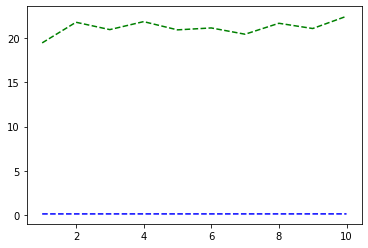

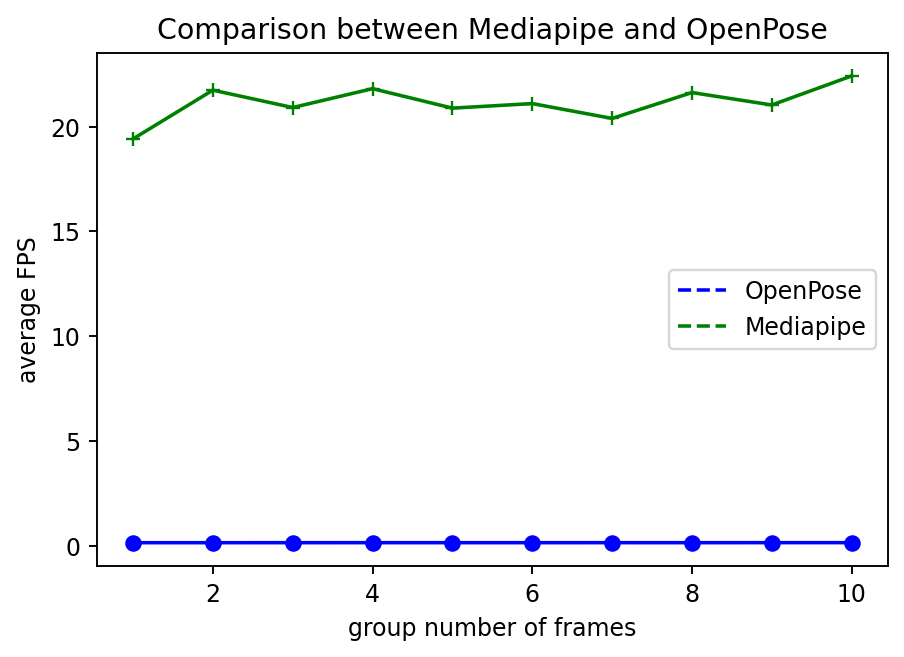

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
O = [0.162, 0.162, 0.1628, 0.1632, 0.1626, 0.1627, 0.1631, 0.1625, 0.1639, 0.1638]
M = [19.4112, 21.7345, 20.9058, 21.8052, 20.8775, 21.0938, 20.3866, 21.6192, 21.0283, 22.4107]
x = [1,2,3,4,5,6,7,8,9,10]

lf, = plt.plot(x,O,'b--',label='OpenPose')  #OpenPose
lm, = plt.plot(x,M,'g--',label='Mediapipe')  #mediapipe

plt.figure(dpi=170)
plt.plot(x,O,'bo-',x,M,'g+-')
plt.title('Comparison between Mediapipe and OpenPose')
plt.xlabel("group number of frames")
plt.ylabel("average FPS")
plt.legend([lf,lm],["OpenPose", "Mediapipe"])

plt.show()